In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rgb_img = cv2.imread('test_img/rgb.jpg')
depth_img = cv2.imread('test_img/depth.png',cv2.IMREAD_UNCHANGED)

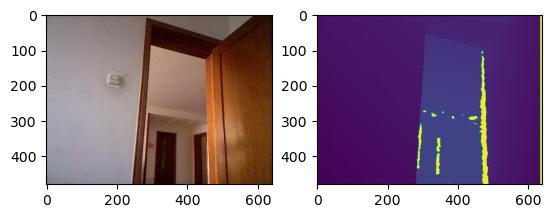

In [3]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(depth_img)

In [52]:
class camera():
    def __init__(self):
        self.ir_intrinsic_matrix = np.array(
            [[590.148060671712, 0, 331.776762806745],
             [0, 586.145968930385, 230.802770705792], [0, 0, 1]])
        self.ir_distortion_matrix = np.array([-0.1093, 0.2668, 0, 0, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[539.020832787886, 0, 325.629602617091],
             [0, 534.861253579807, 256.726953726026], 
             [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
            [0.147555317189259, -0.303342952312001, 0, 0, 0])
        
        
        self.A = np.array([[
    0.999980636769351, -0.00612052930123339, -0.00112481440093692,
    -25.9592777097289
],
          [
              0.00610754444455511, 0.999918558578594, -0.0112059854972665,
              -0.982453053169550
          ],
          [
              0.00119330935703847, 0.0111988986592391, 0.999936578329645,
              4.40757685764124
          ]])
        
    
        img_size = (640, 480)
        return

    def rectify(self):

        return

    def undistortion(self, distorted_img, camera_type):
        # Correcting the distortion
        if camera_type == 'rgb':
            undistorted_img = cv2.undistort(
                distorted_img, self.rgb_intrinsic_matrix,
                self.rgb_distortion_matrix)  # Correcting the distortion
        elif camera_type == 'ir':
            undistorted_img = cv2.undistort(
                distorted_img, self.ir_intrinsic_matrix,
                self.ir_distortion_matrix)  # Correcting the distortion
        return undistorted_img

In [53]:
np.array([[
    0.999980636769351, -0.00612052930123339, -0.00112481440093692,
    -25.9592777097289
],
          [
              0.00610754444455511, 0.999918558578594, -0.0112059854972665,
              -0.982453053169550
          ],
          [
              0.00119330935703847, 0.0111988986592391, 0.999936578329645,
              4.40757685764124
          ], [0, 0, 0, 1]])

array([[ 9.99980637e-01, -6.12052930e-03, -1.12481440e-03,
        -2.59592777e+01],
       [ 6.10754444e-03,  9.99918559e-01, -1.12059855e-02,
        -9.82453053e-01],
       [ 1.19330936e-03,  1.11988987e-02,  9.99936578e-01,
         4.40757686e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [54]:
kinect = camera()

In [55]:
from kinect_smoothing_test import HoleFilling_Filter, Denoising_Filter

hole filled image frames (filled invalid values)


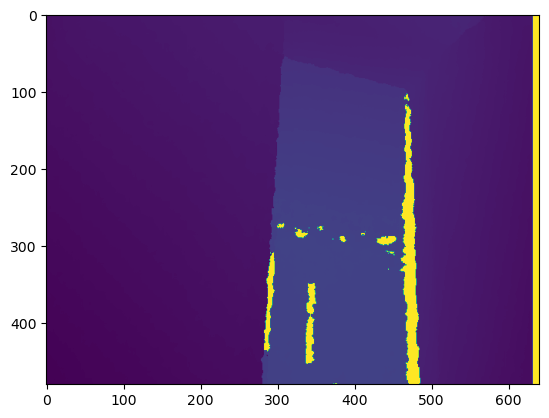

In [56]:
hole_filter = HoleFilling_Filter(flag='fmi',min_valid_depth=200, max_valid_depth=500.)
hf_image = hole_filter.smooth_image(depth_img)
hole_filter = HoleFilling_Filter(flag='min')
hf_image = hole_filter.smooth_image(depth_img)
print('hole filled image frames (filled invalid values)')
plt.imshow(hf_image)
# hf_image = kinect_preprocess(depth_img)

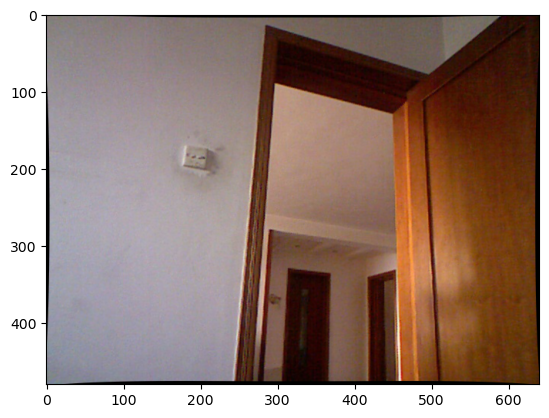

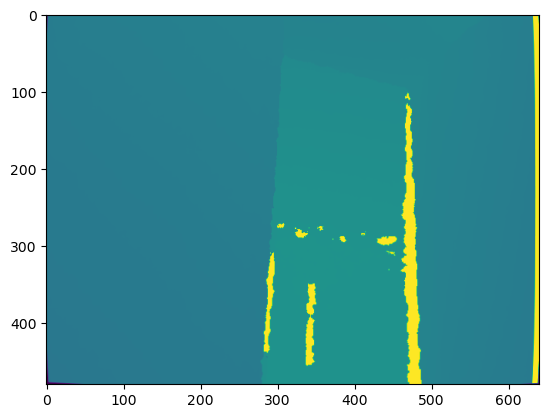

In [57]:
undistorted_rgb_img = kinect.undistortion(rgb_img,'rgb')
plt.imshow( undistorted_rgb_img[:,:,::-1])
plt.show()
undistorted_depth_img = kinect.undistortion(depth_img,'ir')
plt.imshow( undistorted_depth_img)
plt.show()

In [58]:
# dist = 123.6* np.tan(undistorted_depth_img/2842.5 + 1.1863 ).astype(np.float)
# dist = 0.075*585/(1090-undistorted_depth_img)*8*1000
epsilon = 1e-6  # A small constant to avoid division by zero
dist = 0.075 * 585 / (1090 - hf_image + epsilon) * 8*1000 
depth_img.shape

(480, 640)

In [59]:
cx_ir = kinect.ir_intrinsic_matrix[0,2]
cy_ir = kinect.ir_intrinsic_matrix[1,2]
fx_ir = kinect.ir_intrinsic_matrix[0,0]
fy_ir = kinect.ir_intrinsic_matrix[1,1]

In [60]:
def pixel2world(x,y,intrinsic_matrix, dist):
    cx = intrinsic_matrix[0,2]
    cy = intrinsic_matrix[1,2]
    fx = intrinsic_matrix[0,0]
    fy = intrinsic_matrix[1,1]
    Z = dist[y, x]
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return X, Y ,Z
    

In [61]:
dist.shape

(480, 640)

In [62]:
x = np.tile(np.arange(640), (480, 1))
y = np.tile(np.arange(480).reshape(-1, 1), (1, 640))
X,Y,Z = pixel2world(x,y,kinect.ir_intrinsic_matrix, dist)
# Flatten the matrices
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Combine into a single array of 3D points
points_3d = np.vstack((X_flat, Y_flat, Z_flat)).T

In [63]:
 pixel2world(x,y,kinect.ir_intrinsic_matrix, dist)[0].shape

(480, 640)

In [64]:
points_3d.shape

(307200, 3)

<Axes: ylabel='Frequency'>

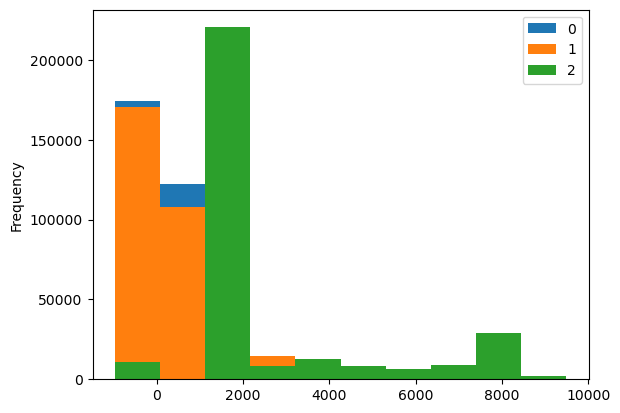

In [65]:
df_point_3d = pd.DataFrame(points_3d[:,:3])
df_point_3d.plot.hist(df_point_3d)

In [66]:
points_3d

array([[-865.48042292, -606.18823471, 1539.47367746],
       [-859.10380102, -603.54112452, 1532.75108501],
       [-856.5065696 , -603.54112452, 1532.75108501],
       ...,
       [   2.81107486,    2.30147863,    5.43520339],
       [   2.82028475,    2.30147863,    5.43520339],
       [   2.82949465,    2.30147863,    5.43520339]])

In [67]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

In [68]:
points_3d.shape

(307200, 3)

In [69]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0).T

In [70]:
raw_pixel = (kinect.rgb_intrinsic_matrix).dot(kinect.A).dot(points_3d.T).T



In [71]:
rgb_pixel = (raw_pixel/(raw_pixel[:,-1].reshape(-1,1))).astype(int)

<Axes: ylabel='Frequency'>

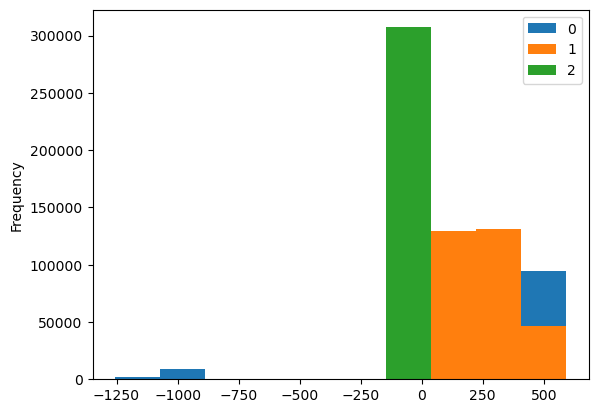

In [72]:
df_rgb_pixel = pd.DataFrame(rgb_pixel)
df_rgb_pixel.plot.hist()

In [73]:
h = points_3d.shape[0]
points_3d_color  = np.zeros((h,3))

In [74]:
for i,v in enumerate(points_3d):
    if rgb_pixel[i][0]>=480 or rgb_pixel[i][1]>=640:
        pc =  np.array([np.nan,np.nan,np.nan])
    elif  rgb_pixel[i][0]<0 or rgb_pixel[i][1]<0:
        pc = np.array([np.nan,np.nan,np.nan])
    else:
        y,x = rgb_pixel[i][:2]
        pc = rgb_img[x,y]
    points_3d_color[i] = pc
    

In [75]:
# Creating a point cloud object
pcd = o3d.geometry.PointCloud()

points_3d[:,0] = points_3d[:,0]
# Assigning the points
pcd.points = o3d.utility.Vector3dVector(points_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1, 0]]/ 255.0)
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])